# Startups operations/close predictions

## Project Setup

### Dependencies

```txt
pandas==2.1.4
seaborn==0.13.2
matplotlib==3.8.2
scipy==1.12.0
scikit-learn==1.4.1.post1
phik==0.12.4
mlxtend==0.23.1
imbalanced-learn==0.12.2

```

In [63]:
import os

from dataclasses import dataclass, field
from datetime import datetime, timedelta
from enum import Enum

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from phik.report import plot_correlation_matrix

In [64]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.combine import SMOTETomek

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler, RobustScaler
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline

from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.impute import SimpleImputer


### Constants


In [65]:
# Environment
# ===========
PRODUCTION = int(os.getenv('DEVELOPMENT', 0)) == 0
DEFAULT_CSV_PATH = '/kaggle/input/startups-operations-close-predictions-m1-35-ds/'
CSV_PATH = os.getenv('CSV_PATH', DEFAULT_CSV_PATH)
CSV_TRAIN = CSV_PATH + 'kaggle_startups_train_28062024.csv'
CSV_TEST = CSV_PATH + 'kaggle_startups_test_28062024.csv'
SUBMISSION_CSV = 'submission.csv'

VERBOSE = True


# ML Config
# =========
RANDOM_STATE = 42
N_ITER = 30
CV_FOLDS = 4


# Date/Time
# =========
YDAYS = 365.25
SNAPSHOT_DATE = datetime(2018, 1, 1)


# Aliases
# =======
RS = RANDOM_STATE
DEV = not PRODUCTION
BR = '\n'


PRODUCTION


False

In [66]:
class Color(Enum):
    PRIMARY = '2b7558'
    SECUNDARY = '2b2f75'

    @property
    def rgb(self) -> str:
        return '#' + self.value


### Datasets

In [67]:
@dataclass
class DFrame:
    train: pd.DataFrame
    test: pd.DataFrame
    val: 'DFrame | None' = None
    cache: dict[str, pd.DataFrame] = field(default_factory=dict)

    def describe(self, is_test: bool = False) -> None:
        dframe_ = self.test if is_test else self.train
        dframe_.info()
        display(dframe_.describe(include='object'))
        display(dframe_.describe(exclude='object'))

    def head_(self, rows: int = 3, verbose: bool = VERBOSE) -> None:
        if verbose:
            print(BR + 'TEST:')
            display(self.test.head(rows))
            print(BR + 'TRAIN:')
        display(self.train.head(rows))

    @staticmethod
    def norm_target(df_: pd.DataFrame, reverse: bool = False) -> pd.DataFrame:
        if reverse:
            df_['status'] = df_['status'].replace({0: 'operating', 1: 'closed'})
            return df_
        else:
            df_['closed'] = df_['status'].map({'operating': 0, 'closed': 1})
            return df_.drop(columns='status')

df = DFrame(train=pd.read_csv(CSV_TRAIN), test=pd.read_csv(CSV_TEST))


In [68]:
df = DFrame(
    train=pd.read_csv(CSV_TRAIN),
    test=pd.read_csv(CSV_TEST),
)


#### Train Data


In [69]:
df.train.head()


,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaN
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaN
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaN
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaN
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaN


In [70]:
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52515 non-null  object 
 1   category_list      50051 non-null  object 
 2   funding_total_usd  42447 non-null  float64
 3   status             52516 non-null  object 
 4   country_code       47014 non-null  object 
 5   state_code         45753 non-null  object 
 6   region             46157 non-null  object 
 7   city               46157 non-null  object 
 8   funding_rounds     52516 non-null  int64  
 9   founded_at         52516 non-null  object 
 10  first_funding_at   52516 non-null  object 
 11  last_funding_at    52516 non-null  object 
 12  closed_at          4917 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 5.2+ MB


,name,category_list,status,country_code,state_code,region,city,founded_at,first_funding_at,last_funding_at,closed_at
count,52515,50051,52516,47014,45753,46157,46157,52516,52516,52516,4917
unique,52515,22105,2,134,300,1036,4477,5402,4603,4305,3008
top,Lunchgate,Software,operating,USA,CA,SF Bay Area,San Francisco,2012-01-01,2013-01-01,2014-01-01,2016-12-02
freq,1,3207,47599,29702,10219,6970,2824,2171,450,369,8


,funding_total_usd,funding_rounds
count,4.244700e+04,52516.000000
mean,1.824748e+07,1.740670
std,1.871173e+08,1.374522
min,1.000000e+00,1.000000
25%,3.360275e+05,1.000000
50%,2.000000e+06,1.000000
75%,1.000000e+07,2.000000
max,3.007950e+10,19.000000


#### Test Data


In [71]:
df.test.head()


,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
0,Crystalsol,Clean Technology,2819200.0,NIC,17,NaN,NaN,1,2009-07-01,2009-07-01,3501
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295
3,Imagine Communications,Software|Video|Video Streaming,34700000.0,USA,CA,San Diego,San Diego,4,2005-01-01,2010-04-20,4748
4,DNA13,Software,4530000.0,CAN,ON,Ottawa,Ottawa,1,2007-05-08,2007-05-08,6209


In [72]:
df.describe(is_test=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               13125 non-null  object 
 1   category_list      12534 non-null  object 
 2   funding_total_usd  10547 non-null  float64
 3   country_code       11743 non-null  object 
 4   state_code         11430 non-null  object 
 5   region             11536 non-null  object 
 6   city               11538 non-null  object 
 7   funding_rounds     13125 non-null  int64  
 8   first_funding_at   13125 non-null  object 
 9   last_funding_at    13125 non-null  object 
 10  lifetime           13125 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 1.1+ MB


,name,category_list,country_code,state_code,region,city,first_funding_at,last_funding_at
count,13125,12534,11743,11430,11536,11538,13125,13125
unique,13125,6206,96,235,688,2117,3299,3021
top,Crystalsol,Software,USA,CA,SF Bay Area,San Francisco,2014-01-01,2014-01-01
freq,1,775,7428,2552,1750,656,126,111


,funding_total_usd,funding_rounds,lifetime
count,1.054700e+04,13125.000000,13125.000000
mean,1.654910e+07,1.714438,3097.609524
std,9.217283e+07,1.318800,2128.356554
min,1.000000e+00,1.000000,52.000000
25%,3.200000e+05,1.000000,1726.000000
50%,2.000000e+06,1.000000,2526.000000
75%,1.000000e+07,2.000000,3866.000000
max,4.715000e+09,15.000000,17167.000000


#### Conclusion (Datasets)


**Differences between datasets**

Train Data:
- `lifetime`

Test Data:
- `founded_at`
- `closed_at`
- `status` (target feature)


**Next, the datasets must be brought into the same structure during pre-processing:**
- The test dataset is the decisive one.
- The column `lifetime` should be created in the training dataset
- and the columns `founded_at` and `closed_at` should be removed as early as possible.


## Pre-processing


In [73]:
# Save Origin Data
# ================
df.cache['origin_train'] = df.train.copy()
df.cache['origin_test'] = df.test.copy()


# Shuffled Train Data
# ===================
df.train = df.train.sample(frac=1, random_state=RS)



### Datetime


In [74]:
def to_datetime(df_: pd.DataFrame, dt_columns: list[str]) -> pd.DataFrame:
    for dt_column in dt_columns:
        df_[dt_column] = pd.to_datetime(df_[dt_column], format='%Y-%m-%d')
    return df_[dt_columns]


In [75]:
df_train_datetime = to_datetime(
    df.train,
    dt_columns=['founded_at', 'first_funding_at', 'last_funding_at', 'closed_at'],
)

df_train_datetime.describe()

,founded_at,first_funding_at,last_funding_at,closed_at
count,52516,52516,52516,4917
mean,2008-11-04 09:44:16.196206848,2011-07-17 04:45:33.247010816,2012-06-27 16:29:42.313961472,2012-01-16 16:14:21.012812800
min,1970-02-05 00:00:00,1977-05-15 00:00:00,1977-05-15 00:00:00,1983-10-06 00:00:00
25%,2006-10-01 00:00:00,2009-10-12 00:00:00,2011-02-01 00:00:00,2009-09-18 00:00:00
50%,2010-10-01 00:00:00,2012-07-23 00:00:00,2013-08-30 00:00:00,2012-09-15 00:00:00
75%,2013-01-01 00:00:00,2014-04-01 00:00:00,2014-11-17 00:00:00,2015-04-23 00:00:00
max,2016-04-02 00:00:00,2015-12-05 00:00:00,2015-12-07 00:00:00,2017-10-21 00:00:00


In [76]:
to_datetime(df.test, dt_columns=['first_funding_at', 'last_funding_at']).describe()


,first_funding_at,last_funding_at
count,13125,13125
mean,2011-07-23 20:54:08.640000,2012-06-16 05:03:41.348571392
min,1973-04-15 00:00:00,1973-04-15 00:00:00
25%,2009-11-16 00:00:00,2011-01-10 00:00:00
50%,2012-08-01 00:00:00,2013-08-21 00:00:00
75%,2014-04-01 00:00:00,2014-11-11 00:00:00
max,2015-12-03 00:00:00,2015-12-12 00:00:00


#### Lifetime


In [77]:
def lifetime(row, snapshot_date: datetime = SNAPSHOT_DATE) -> timedelta:
    if pd.notnull(row['closed_at']):
        return (row['closed_at'] - row['founded_at'])
    return (snapshot_date - row['founded_at'])

In [78]:
df.train['lifetime'] = df.train.apply(lambda x: lifetime(x).days / YDAYS, axis=1)


df.train.sample(3, random_state=RS)


,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,lifetime
51978,Focus Telecom Polska,Communications Infrastructure|Telecommunications,1385003.0,operating,POL,78,Warsaw,Warszawa,1,2012-07-09,2014-04-14,2014-04-14,NaT,5.481177
47716,Dluxdays,Discounts|Fashion|Marketplaces|Personalization...,120195.0,operating,IRL,7,Dublin,Dublin,1,2015-02-13,2015-04-04,2015-04-04,NaT,2.882957
15602,TechFaith Wireless Technology,Business Services|Hardware|Hardware + Software...,38139999.0,operating,CHN,22,Beijing,Beijing,3,2002-01-01,2004-04-01,2009-05-19,NaT,16.000000


In [79]:
df.test['lifetime'] /= YDAYS  # convert to years


df.test.sample(3, random_state=RS)


,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
4975,Idomoo,Enterprise Software,9000000.0,ISR,2,Tel Aviv,Hod Hasharon,1,2013-06-11,2013-06-11,10.001369
11026,VoxPop Network Corporation,Games,3500000.0,USA,CA,SF Bay Area,San Francisco,2,2007-05-01,2009-05-01,11.419576
11797,THUBIT,Artists Globally|Concerts|Events|Social Media|...,400000.0,AUS,7,Melbourne,Melbourne,1,2011-06-01,2011-06-01,6.587269


### Dataframe Validation


In [80]:
# No values for "closed_at"-columns if status is closed and vise versa
# --------------------------------------------------------------------
assert df.train[df.train['status'] == 'closed']['closed_at'].isna().sum() == 0
assert df.train[df.train['status'] == 'operating']['closed_at'].notna().sum() == 0


# Only unique company names
# -------------------------
assert df.train.duplicated(subset='name').sum() == 0


#### Uniform Dataframe Shape


In [81]:
df.train = df.train.drop(columns=['founded_at', 'closed_at'])
df.train = df.train.reindex(list(df.test.columns) + ['status'], axis=1)


# Same shape of both dataframes excluding target column
# -----------------------------------------------------
assert len(df.train.columns) == len(df.test.columns) + 1


df.head_()



TEST:


,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
0,Crystalsol,Clean Technology,2819200.0,NIC,17,NaN,NaN,1,2009-07-01,2009-07-01,9.585216
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,7.438741
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,3.545517



TRAIN:


,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime,status
19273,Permutive,Software,1409067.0,GBR,H9,London,London,2,2013-12-01,2015-05-22,4.999316,operating
52382,Rovux Group Limited,Apps|Software|Software Compliance,12000000.0,HKG,NaN,HKG - Other,Yuen Long,2,2014-03-20,2014-06-04,4.306639,operating
543,On Networks,Games|Video,16000000.0,USA,TX,Austin,Austin,2,2006-11-01,2007-11-01,4.618754,closed


### Missing Values


In [82]:
total_by_round = df.train.pivot_table(
    values='funding_total_usd',
    index='funding_rounds',
    aggfunc='mean'
)

total_by_round.head()

,funding_total_usd
funding_rounds,
1,9.302247e+06
2,1.358623e+07
3,2.260116e+07
4,3.439820e+07
5,7.708196e+07


In [83]:
def fillna_total(row, mapping: dict[int, float] = total_by_round.to_dict()) -> float:
    return mapping['funding_total_usd'][row]

In [84]:
na_ids = df.train['funding_total_usd'].isna()
df.train.loc[na_ids, 'funding_total_usd'] = df.train['funding_rounds'].apply(
    fillna_total
)
na_ids_test = df.test['funding_total_usd'].isna()
df.test.loc[na_ids_test, 'funding_total_usd'] = df.test['funding_rounds'].apply(
    fillna_total
)
 

df.train[na_ids].head()


,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime,status
43294,Lowfoot,Customer Service|Customer Support Tools|Utilities,9.302247e+06,CAN,ON,Toronto,Toronto,1,2012-05-24,2012-05-24,6.231348,operating
19756,Mobilike,Media|Mobile,9.302247e+06,TUR,34,Istanbul,Istanbul,1,2013-09-06,2013-09-06,8.251882,operating
33089,JTT Computer,NaN,9.302247e+06,NaN,NaN,NaN,NaN,1,1999-01-01,1999-01-01,3.457906,closed
9618,JustParts,Auto|E-Commerce|Marketplaces,9.302247e+06,CAN,AB,Thunder Bay,Thunder Bay,1,2013-09-01,2013-09-01,11.838467,operating
31330,Ticket blue,Enterprises|Software,9.302247e+06,USA,NY,New York City,Brooklyn,1,2014-12-18,2014-12-18,3.477070,operating


## EDA I


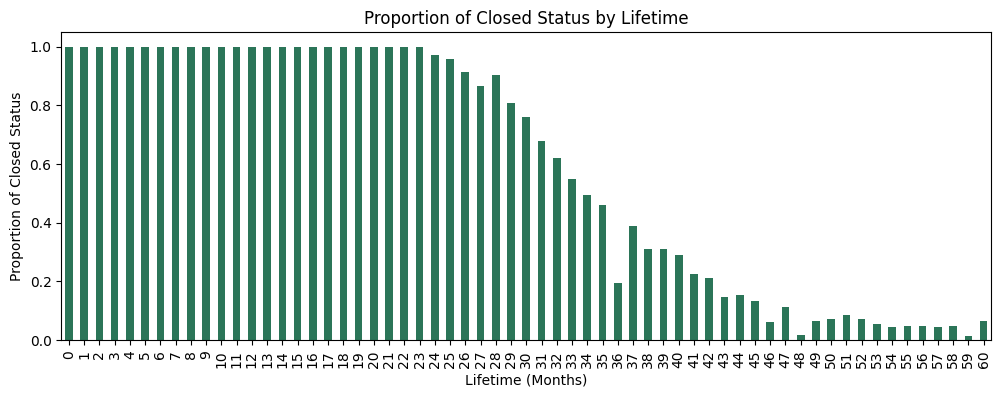

In [85]:

def plot_closed_proportion_by_lifetime(df_: pd.DataFrame, months: int = 12 * 5):
    df_lifetime = df_.copy()
    df_lifetime['year'] = df_lifetime['lifetime'].astype(int)
    df_lifetime['lifetime_months'] = (df_lifetime['lifetime'] * 12).astype(int)

    closed_per_lifetime_months = df_lifetime[df_lifetime['lifetime_months'] <= months]

    closed_per_lifetime = (
        closed_per_lifetime_months[closed_per_lifetime_months['status'] == 'closed']
        .groupby('lifetime_months')
        .size() / closed_per_lifetime_months.groupby('lifetime_months').size()
    )

    plt.figure(figsize=(12, 4))
    closed_per_lifetime.plot(kind='bar', color=Color.PRIMARY.rgb)
    plt.title('Proportion of Closed Status by Lifetime')
    plt.xlabel('Lifetime (Months)')
    plt.ylabel('Proportion of Closed Status')
    plt.show()


plot_closed_proportion_by_lifetime(df.train)

The chart displays a bar graph that shows the proportion of the `closed` status as a function of lifetime in months. The X-axis represents the lifetime in months (from 0 to 60), and the Y-axis shows the proportion of closed cases.

y2
1    51296
0     1220
Name: count, dtype: int64

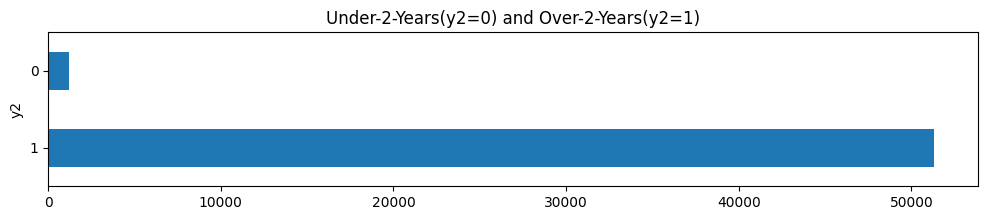

In [86]:
year_threshold = 2.0

df.train['y2'] = (df.train['lifetime'] > year_threshold).astype(int)
df.test['y2'] = (df.test['lifetime'] > year_threshold).astype(int)

df.train['y2'] = df.train['y2'].astype(str)
df.test['y2'] = df.test['y2'].astype(str)

y2 = df.train['y2'].value_counts()


y2.plot(kind='barh', figsize=(12, 2))
plt.title('Under-2-Years(y2=0) and Over-2-Years(y2=1)')


y2

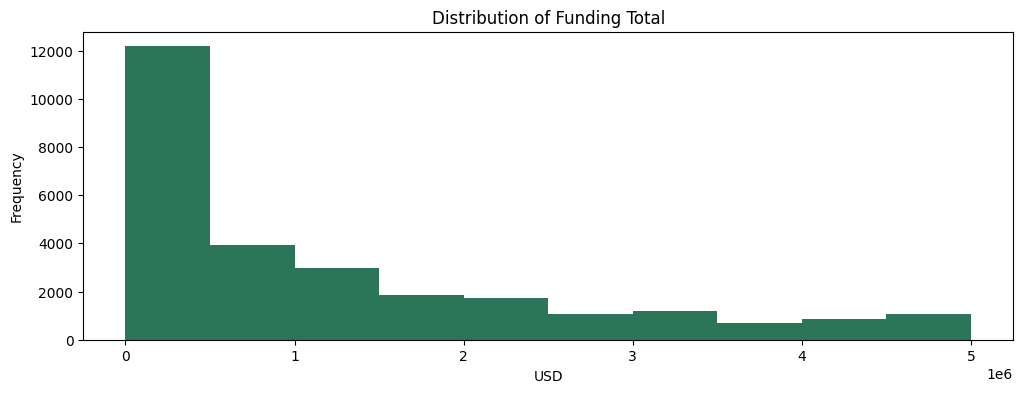

In [87]:
plt.figure(figsize=(12, 4))

plt.hist(
    df.train['funding_total_usd'],
    bins=10,
    color=Color.PRIMARY.rgb,
    range=(0, 5_000_000),
)

plt.title('Distribution of Funding Total')
plt.xlabel('USD')
plt.ylabel('Frequency')


plt.show()

There is a very high number of entries with a funding amount close to 0. The first bar of the histogram is significantly higher than the others, indicating that over 12,000 entries fall into this category.

As the funding amount increases, the frequency of entries decreases sharply. The trend shows a declining curve, suggesting that higher funding amounts are much less common.


## Feuture Synthesis


### Company Labels


In [88]:
def count_labels(row: pd.Series):
    cats_: str = str(row['category_list'])
    if cats_:
        return len(cats_.split('|'))


In [89]:
df.train['labels'] = df.train.apply(count_labels, axis=1)
df.test['labels'] = df.test.apply(count_labels, axis=1)


df.head_()



TEST:


,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime,y2,labels
0,Crystalsol,Clean Technology,2.819200e+06,NIC,17,NaN,NaN,1,2009-07-01,2009-07-01,9.585216,1,1
1,JBI Fish & Wings,Hospitality,9.302247e+06,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,7.438741,1,1
2,COINPLUS,Finance,4.282570e+05,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,3.545517,1,1



TRAIN:


,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime,status,y2,labels
19273,Permutive,Software,1409067.0,GBR,H9,London,London,2,2013-12-01,2015-05-22,4.999316,operating,1,1
52382,Rovux Group Limited,Apps|Software|Software Compliance,12000000.0,HKG,NaN,HKG - Other,Yuen Long,2,2014-03-20,2014-06-04,4.306639,operating,1,3
543,On Networks,Games|Video,16000000.0,USA,TX,Austin,Austin,2,2006-11-01,2007-11-01,4.618754,closed,1,2


In [90]:
def add_category_columns(
    df: pd.DataFrame,
    category_prefixes: list[str] = ['c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7','c8']
) -> pd.DataFrame:

    exploded_df = df['category_list'].str.split('|').explode().reset_index()
    exploded_df['count'] = exploded_df.groupby('index')['category_list'].transform(
        'count'
    )
    exploded_df = exploded_df.sort_values(
        by=['index', 'count'], ascending=[True, False]
    )
    top_categories = exploded_df.groupby('index').head(len(category_prefixes))
    final_df = df.copy()
    for i, prefix in enumerate(category_prefixes):
        nth_category = (
            top_categories.groupby('index').nth(i)['category_list']
            .reset_index(drop=True)
        )
        final_df[f'{prefix}_cat'] = nth_category.reindex(df.index).fillna('None')

    return final_df

In [91]:
df.train = add_category_columns(df.train).drop(columns='category_list')
df.test = add_category_columns(df.test).drop(columns='category_list')


df.head_()



TEST:


,name,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime,y2,labels,c1_cat,c2_cat,c3_cat,c4_cat,c5_cat,c6_cat,c7_cat,c8_cat
0,Crystalsol,2.819200e+06,NIC,17,NaN,NaN,1,2009-07-01,2009-07-01,9.585216,1,1,Clean Technology,Video,Video Streaming,Telephony,Neuroscience,Search,Software,Web Development
1,JBI Fish & Wings,9.302247e+06,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,7.438741,1,1,Hospitality,Entertainment,Games,Optimization,Startups,Technology,Promotional,SaaS
2,COINPLUS,4.282570e+05,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,3.545517,1,1,Finance,Medical,Therapeutics,Travel,Universities,Monetization,Virtualization,Web Hosting



TRAIN:


,name,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime,...,y2,labels,c1_cat,c2_cat,c3_cat,c4_cat,c5_cat,c6_cat,c7_cat,c8_cat
19273,Permutive,1409067.0,GBR,H9,London,London,2,2013-12-01,2015-05-22,4.999316,...,1,1,Software,Entertainment,SaaS,None,None,None,None,None
52382,Rovux Group Limited,12000000.0,HKG,NaN,HKG - Other,Yuen Long,2,2014-03-20,2014-06-04,4.306639,...,1,3,Apps,None,None,None,None,None,None,None
543,On Networks,16000000.0,USA,TX,Austin,Austin,2,2006-11-01,2007-11-01,4.618754,...,1,2,Games,Big Data,Technology,Services,Mobile,Mobile,NFC,Music


In [92]:
for cat_ in ['c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8']:
    cat_ = cat_ + '_cat'
    cn_fx = df.train[cat_].value_counts().to_dict()
    df.train[cat_] = df.train[cat_].apply(lambda x: cn_fx.get(x))
    df.test[cat_] = df.test[cat_].apply(lambda x: cn_fx.get(x))



df.head_()



TEST:


,name,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime,y2,labels,c1_cat,c2_cat,c3_cat,c4_cat,c5_cat,c6_cat,c7_cat,c8_cat
0,Crystalsol,2.819200e+06,NIC,17,NaN,NaN,1,2009-07-01,2009-07-01,9.585216,1,1,1106.0,139.0,59.0,10.0,3.0,38.0,144.0,18.0
1,JBI Fish & Wings,9.302247e+06,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,7.438741,1,1,384.0,178.0,195.0,24.0,78.0,69.0,5.0,36.0
2,COINPLUS,4.282570e+05,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,3.545517,1,1,873.0,340.0,97.0,90.0,4.0,4.0,11.0,6.0



TRAIN:


,name,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime,...,y2,labels,c1_cat,c2_cat,c3_cat,c4_cat,c5_cat,c6_cat,c7_cat,c8_cat
19273,Permutive,1409067.0,GBR,H9,London,London,2,2013-12-01,2015-05-22,4.999316,...,1,1,3322,178,399,41945,46921,49170,50593,51379
52382,Rovux Group Limited,12000000.0,HKG,NaN,HKG - Other,Yuen Long,2,2014-03-20,2014-06-04,4.306639,...,1,3,1184,26057,32276,41945,46921,49170,50593,51379
543,On Networks,16000000.0,USA,TX,Austin,Austin,2,2006-11-01,2007-11-01,4.618754,...,1,2,1014,341,476,91,283,166,6,6


### Location


In [93]:
def create_location(df_: pd.DataFrame, limiter: str = ' / '):
    _limiter_ = '( ' * 3 + limiter + ' )' * 3
    df_['location'] = df_['country_code'].fillna('') + _limiter_
    df_['location'] = df_['location'] + df_['state_code'].fillna('1') + _limiter_
    df_['location'] = df_['location'] + df_['region'].fillna('2') + _limiter_
    df_['location'] = df_['location'] + df_['city'].fillna('3')
    expression = _limiter_ + _limiter_.join(['1', '2', '3'])
    df_.loc[df_['location'] == expression, 'location'] = 'Unknown'
    df_['location'] = df_['location'].str.replace( _limiter_.join(['1', '2', '3']), '')
    df_['location'] = df_['location'].str.replace(_limiter_.join(['2', '3']), '')
    df_['location'] = df_['location'].str.removesuffix(_limiter_)
    df_['location'] = df_['location'].str.replace(_limiter_, limiter)


In [94]:
create_location(df.train)
create_location(df.test)


# Example with Unknown Region and City
# ====================================
df.train[df.train['name'].isin(['Caption Data', 'Escoublac'])]


,name,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime,...,labels,c1_cat,c2_cat,c3_cat,c4_cat,c5_cat,c6_cat,c7_cat,c8_cat,location
1763,Caption Data,152000.0,GBR,Q4,NaN,NaN,1,2014-01-17,2014-01-17,10.001369,...,1,688,38,5,37,7,26,17,51379,GBR / Q4
874,Escoublac,6650000.0,USA,MA,NaN,NaN,1,2008-01-09,2008-01-09,1.637235,...,1,3592,8,87,9,8,1,55,1,USA / MA


In [95]:
df.cache['df_test_location'] = df.test.copy()
df.cache['df_train_location'] = df.train.copy()

df.train = df.train.drop(columns=['state_code', 'region', 'city', 'location'])
df.test = df.test.drop(columns=['state_code', 'region', 'city', 'location'])


df.head_()



TEST:


,name,funding_total_usd,country_code,funding_rounds,first_funding_at,last_funding_at,lifetime,y2,labels,c1_cat,c2_cat,c3_cat,c4_cat,c5_cat,c6_cat,c7_cat,c8_cat
0,Crystalsol,2.819200e+06,NIC,1,2009-07-01,2009-07-01,9.585216,1,1,1106.0,139.0,59.0,10.0,3.0,38.0,144.0,18.0
1,JBI Fish & Wings,9.302247e+06,USA,1,2010-07-28,2010-07-28,7.438741,1,1,384.0,178.0,195.0,24.0,78.0,69.0,5.0,36.0
2,COINPLUS,4.282570e+05,LUX,2,2014-05-15,2014-09-18,3.545517,1,1,873.0,340.0,97.0,90.0,4.0,4.0,11.0,6.0



TRAIN:


,name,funding_total_usd,country_code,funding_rounds,first_funding_at,last_funding_at,lifetime,status,y2,labels,c1_cat,c2_cat,c3_cat,c4_cat,c5_cat,c6_cat,c7_cat,c8_cat
19273,Permutive,1409067.0,GBR,2,2013-12-01,2015-05-22,4.999316,operating,1,1,3322,178,399,41945,46921,49170,50593,51379
52382,Rovux Group Limited,12000000.0,HKG,2,2014-03-20,2014-06-04,4.306639,operating,1,3,1184,26057,32276,41945,46921,49170,50593,51379
543,On Networks,16000000.0,USA,2,2006-11-01,2007-11-01,4.618754,closed,1,2,1014,341,476,91,283,166,6,6


#### Country


In [96]:
df.cache['country_occurance_by_country_code'] = (
    df.train['country_code'].value_counts()
)


df.cache['country_occurance_by_country_code'].head()


country_code
USA    29702
GBR     2925
CAN     1540
IND     1276
CHN     1240
Name: count, dtype: int64

In [97]:
def country_category(row: pd.Series) -> pd.Series:
    if row['country_code'] == 'USA':
        return 'USA'
    if row['country_code'] == 'GBR':
        return 'GBR'
    if row['country_code'] == 'NA':
        return 'NA'
    return None


df.train['country_code'] = df.train['country_code'].fillna('NA')
df.train['country'] = df.train.apply(country_category, axis=1)
df.test['country_code'] = df.test['country_code'].fillna('NA')
df.test['country'] = df.test.apply(country_category, axis=1)


df.head_()



TEST:


,name,funding_total_usd,country_code,funding_rounds,first_funding_at,last_funding_at,lifetime,y2,labels,c1_cat,c2_cat,c3_cat,c4_cat,c5_cat,c6_cat,c7_cat,c8_cat,country
0,Crystalsol,2.819200e+06,NIC,1,2009-07-01,2009-07-01,9.585216,1,1,1106.0,139.0,59.0,10.0,3.0,38.0,144.0,18.0,None
1,JBI Fish & Wings,9.302247e+06,USA,1,2010-07-28,2010-07-28,7.438741,1,1,384.0,178.0,195.0,24.0,78.0,69.0,5.0,36.0,USA
2,COINPLUS,4.282570e+05,LUX,2,2014-05-15,2014-09-18,3.545517,1,1,873.0,340.0,97.0,90.0,4.0,4.0,11.0,6.0,None



TRAIN:


,name,funding_total_usd,country_code,funding_rounds,first_funding_at,last_funding_at,lifetime,status,y2,labels,c1_cat,c2_cat,c3_cat,c4_cat,c5_cat,c6_cat,c7_cat,c8_cat,country
19273,Permutive,1409067.0,GBR,2,2013-12-01,2015-05-22,4.999316,operating,1,1,3322,178,399,41945,46921,49170,50593,51379,GBR
52382,Rovux Group Limited,12000000.0,HKG,2,2014-03-20,2014-06-04,4.306639,operating,1,3,1184,26057,32276,41945,46921,49170,50593,51379,None
543,On Networks,16000000.0,USA,2,2006-11-01,2007-11-01,4.618754,closed,1,2,1014,341,476,91,283,166,6,6,USA


### Event Related Features


In [98]:
def _create_since_1st_fund(row) -> timedelta:
    return (SNAPSHOT_DATE - row['first_funding_at'])


def _create_since_last_fund(row) -> timedelta:
    return (SNAPSHOT_DATE - row['last_funding_at'])


def create_since_and_til_1st_fund(df_: pd.DataFrame) -> None:
    df_['since_1st_fund'] = df_.apply(
        lambda x: _create_since_1st_fund(x).days / YDAYS,
        axis=1,
    )
    df_['til_1st_fund'] = df_['lifetime'] - df_['since_1st_fund']


def create_since_and_til_last_fund(df_: pd.DataFrame) -> None:
    df_['since_last_fund'] = df_.apply(
        lambda x: _create_since_last_fund(x).days / YDAYS,
        axis=1,
    )
    df_['til_last_fund'] = df_['lifetime'] - df_['since_last_fund']


def create_fund_span(df_: pd.DataFrame) -> pd.DataFrame:
    years_between_first_and_last_funding = 'fund_span'
    df_[years_between_first_and_last_funding] = (
        (df_['last_funding_at'] - df_['first_funding_at']) / pd.Timedelta(days=YDAYS)
    )
    df_.drop(columns=['first_funding_at', 'last_funding_at'], inplace=True)
    return df_


def funding_dynamics_index(row: pd.Series):
    til_1st_fund = row.get('til_1st_fund', 0)
    since_last_fund = row.get('since_last_fund', 0)
    funding_rounds = row.get('funding_rounds', 1)
    lifetime = row.get('lifetime', 1)
    return (til_1st_fund + (since_last_fund / funding_rounds)) / lifetime

In [99]:
create_since_and_til_1st_fund(df.train)
create_since_and_til_1st_fund(df.test)

create_since_and_til_last_fund(df.train)
create_since_and_til_last_fund(df.test)


df.head_()



TEST:


,name,funding_total_usd,country_code,funding_rounds,first_funding_at,last_funding_at,lifetime,y2,labels,c1_cat,...,c4_cat,c5_cat,c6_cat,c7_cat,c8_cat,country,since_1st_fund,til_1st_fund,since_last_fund,til_last_fund
0,Crystalsol,2.819200e+06,NIC,1,2009-07-01,2009-07-01,9.585216,1,1,1106.0,...,10.0,3.0,38.0,144.0,18.0,None,8.503765,1.081451,8.503765,1.081451
1,JBI Fish & Wings,9.302247e+06,USA,1,2010-07-28,2010-07-28,7.438741,1,1,384.0,...,24.0,78.0,69.0,5.0,36.0,USA,7.430527,0.008214,7.430527,0.008214
2,COINPLUS,4.282570e+05,LUX,2,2014-05-15,2014-09-18,3.545517,1,1,873.0,...,90.0,4.0,4.0,11.0,6.0,None,3.633128,-0.087611,3.288159,0.257358



TRAIN:


,name,funding_total_usd,country_code,funding_rounds,first_funding_at,last_funding_at,lifetime,status,y2,labels,...,c4_cat,c5_cat,c6_cat,c7_cat,c8_cat,country,since_1st_fund,til_1st_fund,since_last_fund,til_last_fund
19273,Permutive,1409067.0,GBR,2,2013-12-01,2015-05-22,4.999316,operating,1,1,...,41945,46921,49170,50593,51379,GBR,4.084873,0.914442,2.614648,2.384668
52382,Rovux Group Limited,12000000.0,HKG,2,2014-03-20,2014-06-04,4.306639,operating,1,3,...,41945,46921,49170,50593,51379,None,3.786448,0.520192,3.578371,0.728268
543,On Networks,16000000.0,USA,2,2006-11-01,2007-11-01,4.618754,closed,1,2,...,91,283,166,6,6,USA,11.167693,-6.548939,10.168378,-5.549624


In [100]:
create_fund_span(df.test)
create_fund_span(df.train)

df.train['fx_dynamics'] = df.train.apply(funding_dynamics_index, axis=1)
df.test['fx_dynamics'] = df.test.apply(funding_dynamics_index, axis=1)


df.head_()



TEST:


,name,funding_total_usd,country_code,funding_rounds,lifetime,y2,labels,c1_cat,c2_cat,c3_cat,...,c6_cat,c7_cat,c8_cat,country,since_1st_fund,til_1st_fund,since_last_fund,til_last_fund,fund_span,fx_dynamics
0,Crystalsol,2.819200e+06,NIC,1,9.585216,1,1,1106.0,139.0,59.0,...,38.0,144.0,18.0,None,8.503765,1.081451,8.503765,1.081451,0.000000,1.000000
1,JBI Fish & Wings,9.302247e+06,USA,1,7.438741,1,1,384.0,178.0,195.0,...,69.0,5.0,36.0,USA,7.430527,0.008214,7.430527,0.008214,0.000000,1.000000
2,COINPLUS,4.282570e+05,LUX,2,3.545517,1,1,873.0,340.0,97.0,...,4.0,11.0,6.0,None,3.633128,-0.087611,3.288159,0.257358,0.344969,0.438996



TRAIN:


,name,funding_total_usd,country_code,funding_rounds,lifetime,status,y2,labels,c1_cat,c2_cat,...,c6_cat,c7_cat,c8_cat,country,since_1st_fund,til_1st_fund,since_last_fund,til_last_fund,fund_span,fx_dynamics
19273,Permutive,1409067.0,GBR,2,4.999316,operating,1,1,3322,178,...,49170,50593,51379,GBR,4.084873,0.914442,2.614648,2.384668,1.470226,0.444414
52382,Rovux Group Limited,12000000.0,HKG,2,4.306639,operating,1,3,1184,26057,...,49170,50593,51379,None,3.786448,0.520192,3.578371,0.728268,0.208077,0.536236
543,On Networks,16000000.0,USA,2,4.618754,closed,1,2,1014,341,...,166,6,6,USA,11.167693,-6.548939,10.168378,-5.549624,0.999316,-0.317131


In [101]:
df.train['last1st_index'] = df.train['til_last_fund'] / df.train['since_1st_fund']
df.test['last1st_index'] = df.test['til_last_fund'] / df.test['since_1st_fund']


df.head_()



TEST:


,name,funding_total_usd,country_code,funding_rounds,lifetime,y2,labels,c1_cat,c2_cat,c3_cat,...,c7_cat,c8_cat,country,since_1st_fund,til_1st_fund,since_last_fund,til_last_fund,fund_span,fx_dynamics,last1st_index
0,Crystalsol,2.819200e+06,NIC,1,9.585216,1,1,1106.0,139.0,59.0,...,144.0,18.0,None,8.503765,1.081451,8.503765,1.081451,0.000000,1.000000,0.127173
1,JBI Fish & Wings,9.302247e+06,USA,1,7.438741,1,1,384.0,178.0,195.0,...,5.0,36.0,USA,7.430527,0.008214,7.430527,0.008214,0.000000,1.000000,0.001105
2,COINPLUS,4.282570e+05,LUX,2,3.545517,1,1,873.0,340.0,97.0,...,11.0,6.0,None,3.633128,-0.087611,3.288159,0.257358,0.344969,0.438996,0.070836



TRAIN:


,name,funding_total_usd,country_code,funding_rounds,lifetime,status,y2,labels,c1_cat,c2_cat,...,c7_cat,c8_cat,country,since_1st_fund,til_1st_fund,since_last_fund,til_last_fund,fund_span,fx_dynamics,last1st_index
19273,Permutive,1409067.0,GBR,2,4.999316,operating,1,1,3322,178,...,50593,51379,GBR,4.084873,0.914442,2.614648,2.384668,1.470226,0.444414,0.583780
52382,Rovux Group Limited,12000000.0,HKG,2,4.306639,operating,1,3,1184,26057,...,50593,51379,None,3.786448,0.520192,3.578371,0.728268,0.208077,0.536236,0.192336
543,On Networks,16000000.0,USA,2,4.618754,closed,1,2,1014,341,...,6,6,USA,11.167693,-6.548939,10.168378,-5.549624,0.999316,-0.317131,-0.496936


In [102]:
df.train['root_years'] = df.train['lifetime'] ** 0.5
df.test['root_years'] = df.test['lifetime'] ** 0.5


df.head_()



TEST:


,name,funding_total_usd,country_code,funding_rounds,lifetime,y2,labels,c1_cat,c2_cat,c3_cat,...,c8_cat,country,since_1st_fund,til_1st_fund,since_last_fund,til_last_fund,fund_span,fx_dynamics,last1st_index,root_years
0,Crystalsol,2.819200e+06,NIC,1,9.585216,1,1,1106.0,139.0,59.0,...,18.0,None,8.503765,1.081451,8.503765,1.081451,0.000000,1.000000,0.127173,3.096000
1,JBI Fish & Wings,9.302247e+06,USA,1,7.438741,1,1,384.0,178.0,195.0,...,36.0,USA,7.430527,0.008214,7.430527,0.008214,0.000000,1.000000,0.001105,2.727405
2,COINPLUS,4.282570e+05,LUX,2,3.545517,1,1,873.0,340.0,97.0,...,6.0,None,3.633128,-0.087611,3.288159,0.257358,0.344969,0.438996,0.070836,1.882954



TRAIN:


,name,funding_total_usd,country_code,funding_rounds,lifetime,status,y2,labels,c1_cat,c2_cat,...,c8_cat,country,since_1st_fund,til_1st_fund,since_last_fund,til_last_fund,fund_span,fx_dynamics,last1st_index,root_years
19273,Permutive,1409067.0,GBR,2,4.999316,operating,1,1,3322,178,...,51379,GBR,4.084873,0.914442,2.614648,2.384668,1.470226,0.444414,0.583780,2.235915
52382,Rovux Group Limited,12000000.0,HKG,2,4.306639,operating,1,3,1184,26057,...,51379,None,3.786448,0.520192,3.578371,0.728268,0.208077,0.536236,0.192336,2.075244
543,On Networks,16000000.0,USA,2,4.618754,closed,1,2,1014,341,...,6,USA,11.167693,-6.548939,10.168378,-5.549624,0.999316,-0.317131,-0.496936,2.149129


### Investment Related Features

In [103]:
def invest_size(row: pd.Series, tresholds_k: list[int] = [1_000, 5_000]) -> str:
    if row['funding_total_usd'] < tresholds_k[0] * 1_000:
        return 'low'
    if tresholds_k[0] * 1_000 <= row['funding_total_usd'] < tresholds_k[1] * 1_000:
        return 'medium'
    return 'high'



df.train['invest_size'] = df.train.apply(invest_size, axis=1)
df.test['invest_size'] = df.test.apply(invest_size, axis=1)


df.train['invest_size'].value_counts()


invest_size
high      25454
low       16099
medium    10963
Name: count, dtype: int64

## EDA II


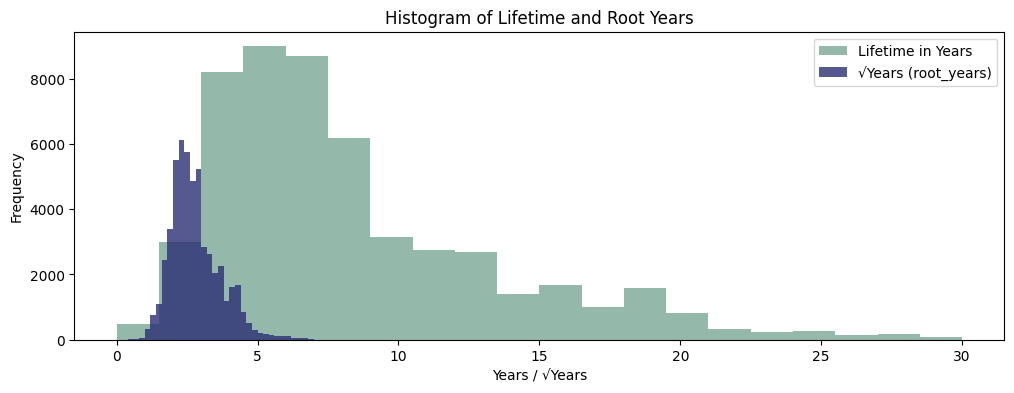

In [104]:
plt.figure(figsize=(12, 4))
plt.hist(
    df.train['lifetime'],
    bins=20,
    color=Color.PRIMARY.rgb,
    alpha=0.5,
    range=(0, 30),
    label='Lifetime in Years'
)
plt.hist(
    df.train['root_years'],
    bins=150,
    color=Color.SECUNDARY.rgb,
    alpha=0.8,
    range=(0, 30),
    label='√Years (root_years)'
)
plt.title('Histogram of Lifetime and Root Years')
plt.xlabel('Years / √Years')
plt.ylabel('Frequency')
plt.legend()
plt.grid(False)
plt.show()

This representation is intended to illustrate the effects of the square root transformation on the data. While the green distribution shows a broader range with a gradual decrease in frequency, the blue distribution is more concentrated and exhibits a higher density in the initial years. This transformation can be useful for normalizing the data and better identifying linear relationships, particularly in machine learning.


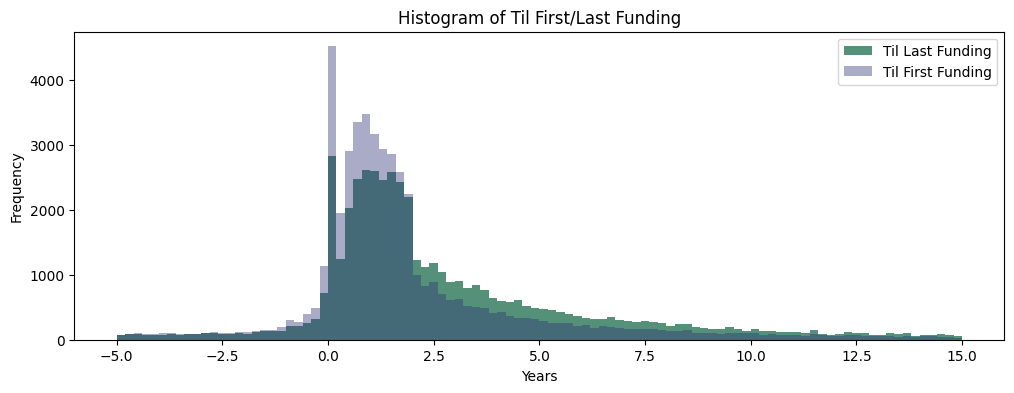

In [105]:
bins_, range_ = 100, (-5, 15)

plt.figure(figsize=(12, 4))
plt.hist(
    df.train['til_last_fund'],
    bins=bins_,
    color=Color.PRIMARY.rgb,
    alpha=0.8,
    range=range_,
    label='Til Last Funding'
)
plt.hist(
    df.train['til_1st_fund'],
    bins=bins_,
    color=Color.SECUNDARY.rgb,
    alpha=0.4,
    range=range_,
    label='Til First Funding'
)
plt.title('Histogram of Til First/Last Funding')
plt.xlabel('Years')
plt.ylabel('Frequency')
plt.legend()
plt.grid(False)
plt.show()

There is a significant overlap between the two distributions, particularly in the early years. This suggests that the first and last funding rounds often occur relatively close to each other.

The noticeable peak at the beginning of the chart could indicate that many companies receive their first or last funding very early in their lifespan. One possible reason for this is that these companies may only be officially founded after securing funding.

The chart shows negative values, which suggests that there are data points occurring before the reference point (0 years). However, this is not relevant because these are synthetic features that use the `lifetime` attribute instead of the actual timestamps like `closed_at` or `funding_at`. This approach was chosen because the test dataset only contains the `lifetime` feature, and the other timestamps are missing. Therefore, the negative values are a result of how these synthetic features were calculated.

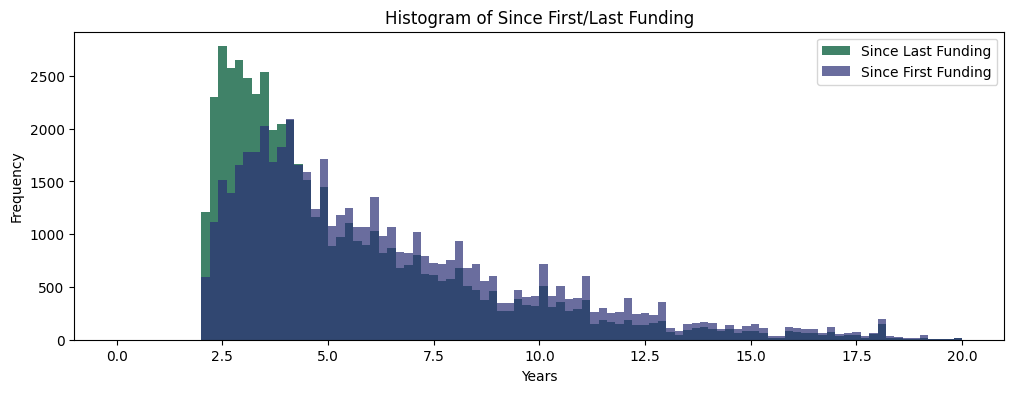

In [106]:
bins_, range_ = 100, (0, 20)

plt.figure(figsize=(12, 4))

plt.hist(
    df.train['since_last_fund'],
    bins=bins_,
    color=Color.PRIMARY.rgb,
    alpha=0.9,
    range=range_,
    label='Since Last Funding'
)
plt.hist(
    df.train['since_1st_fund'],
    bins=bins_,
    color=Color.SECUNDARY.rgb,
    alpha=0.7,
    range=range_,
    label='Since First Funding'
)

plt.title('Histogram of Since First/Last Funding')
plt.xlabel('Years')
plt.ylabel('Frequency')
plt.legend()
plt.grid(False)
plt.show()

The chart provides an overview of how long it has been since companies received their first and last funding. It shows that most funding rounds occur within the first few years after a company's founding, and there is a common period of around 2.5 to 7 years during which both the first and last funding rounds frequently occur.

## Correlation


In [107]:
def correlation_mtx(df_: pd.DataFrame, *columns: list[str]) -> None:
    phik_data = pd.get_dummies(
        df_[[*columns]],
        drop_first=True
    )
    phik_matrix = phik_data[phik_data.columns].phik_matrix(
        interval_cols=phik_data.columns
    )
    plot_correlation_matrix(
        phik_matrix.values,
        x_labels=phik_matrix.columns,
        y_labels=phik_matrix.index,
        title=r"Correlation $\phi_K$",
        fontsize_factor=0.9,
        figsize=(12, 9),
        top=50,
    )

In [108]:
df.train = df.norm_target(df.train)


df.train.head()


,name,funding_total_usd,country_code,funding_rounds,lifetime,y2,labels,c1_cat,c2_cat,c3_cat,...,since_1st_fund,til_1st_fund,since_last_fund,til_last_fund,fund_span,fx_dynamics,last1st_index,root_years,invest_size,closed
19273,Permutive,1.409067e+06,GBR,2,4.999316,1,1,3322,178,399,...,4.084873,0.914442,2.614648,2.384668,1.470226,0.444414,0.583780,2.235915,medium,0
52382,Rovux Group Limited,1.200000e+07,HKG,2,4.306639,1,3,1184,26057,32276,...,3.786448,0.520192,3.578371,0.728268,0.208077,0.536236,0.192336,2.075244,high,0
543,On Networks,1.600000e+07,USA,2,4.618754,1,2,1014,341,476,...,11.167693,-6.548939,10.168378,-5.549624,0.999316,-0.317131,-0.496936,2.149129,high,1
43294,Lowfoot,9.302247e+06,CAN,1,6.231348,1,3,150,26057,32276,...,5.607118,0.624230,5.607118,0.624230,0.000000,1.000000,0.111328,2.496267,high,0
34941,Cenzic,1.600000e+07,USA,2,18.001369,1,1,362,26057,32276,...,12.476386,5.524983,6.644764,11.356605,5.831622,0.491483,0.910248,4.242802,high,0


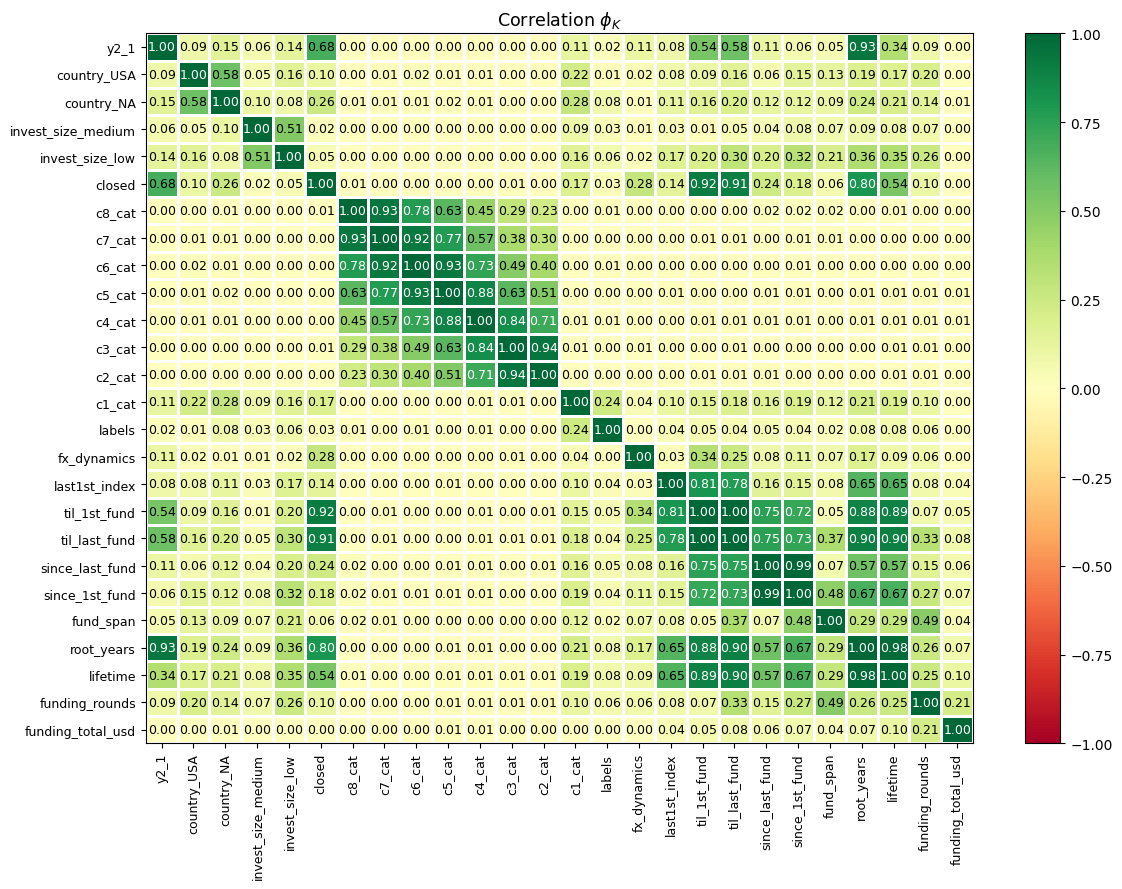

In [109]:
correlation_mtx(
    df.train,
    'funding_total_usd',
    'invest_size',
    'funding_rounds',
    'lifetime',
    'root_years',
    'fund_span',
    'since_1st_fund',
    'since_last_fund',
    'til_last_fund',
    'til_1st_fund',
    'last1st_index',
    'fx_dynamics',
    'labels',
    'c1_cat',
    'c2_cat',
    'c3_cat',
    'c4_cat',
    'c5_cat',
    'c6_cat',
    'c7_cat',
    'c8_cat',
    'country',
    'y2',
    'closed',
)

Highly correlated features should be removed because they can be redundant and contribute little additional information to the analysis or the model. When two or more features are strongly correlated, they essentially provide the same information. This can lead to issues such as multicollinearity, which can negatively affect the stability and interpretability of a model.


## Model Training


In [110]:
dev_mode_snippet = 'MODE: Production'
if DEV:
    dev_mode_snippet = 'MODE: Development'
    sample_size = 40_000
    df.train = df.train.sample(sample_size, random_state=RS)
    print(
        BR + dev_mode_snippet,
        'sample size (df.train): ' + str(sample_size) + BR,
        sep=BR
    )

test_size = 0.2
test_size_l2 = 0.6


test_size, test_size_l2


MODE: Development
sample size (df.train): 40000



(0.2, 0.6)

In [111]:
# Validation Split I
# ==================
df_val_train: pd.DataFrame
df_val_test_: pd.DataFrame

df_val_train, df_val_test_ = train_test_split(
    df.train.copy(),
    test_size=test_size,
    random_state=RS,
    stratify=df.train['closed'],
)
df.val = DFrame(train=df_val_train, test=df_val_test_)

# Xy ML-Training
# --------------
X_train = df.val.train.drop(columns=['closed'])
y_train = df.val.train['closed']


# Validation Split II
# ===================
df_val_test_1: pd.DataFrame
df_val_test_2: pd.DataFrame
df_val_test_1, df_val_test_2 = train_test_split(
    df_val_test_.copy(),
    test_size=test_size_l2,
    random_state=RS,
    stratify=df_val_test_['closed'],
)
df.val.val = DFrame(train=df_val_test_1, test=df_val_test_2)

# Xy Validation
# -------------
validation: dict[str, dict[str, pd.DataFrame]] = {
    'val_100': {
        f'X': df.val.test.drop(columns=['closed']), 
        f'y': df.val.test['closed']
    },
    f'test_{int(test_size_l2*100)}': {
        f'X': df.val.val.test.drop(columns=['closed']), 
        f'y': df.val.val.test['closed']
    },
    f'val_{int((1-test_size_l2)*100)}': {
        f'X': df.val.val.train.drop(columns=['closed']),
        f'y': df.val.val.train['closed']
    },
}


tuple(validation.keys())

('val_100', 'test_60', 'val_40')

In [112]:
# Split Strategy Overview
# =======================
df_test_ratio = len(df.test)/(len(df.train)+len(df.test))
df_train_ratio = len(df.train)/(len(df.train)+len(df.test))
shape_l1 = {
    f'- df.test {df_test_ratio:.2%} (Kaggle)': df.test.shape,
    f'- df.train {df_train_ratio:.2%} ({dev_mode_snippet})': df.train.shape,
    '- df.val': ' < - '+' - '*15+'df.train.copy()'
}
shape_l2 = {
    f'- df.val.test {test_size:.0%}': df.val.test.shape,
    f'- df.val.train {1-test_size:.0%}(ML/CV)': df.val.train.shape,
    '- df.val.val': '  < - '+' - '*12+'df.val.test.copy()'
}
shape_l3 = {
    f'- df.val.test {test_size_l2:.0%}': df.val.val.test.shape,
    f'- df.val.train {1-test_size_l2:.0%}': df.val.val.train.shape,
}
shapes = {**shape_l1, **shape_l2, **shape_l3}


for row, key in enumerate(shapes):
    print(' '*4*int(row / 3), key + ' : ', shapes[key])

 - df.test 24.71% (Kaggle) :  (13125, 25)
 - df.train 75.29% (MODE: Development) :  (40000, 26)
 - df.val :   < -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  - df.train.copy()
     - df.val.test 20% :  (8000, 26)
     - df.val.train 80%(ML/CV) :  (32000, 26)
     - df.val.val :    < -  -  -  -  -  -  -  -  -  -  -  -  - df.val.test.copy()
         - df.val.test 60% :  (4800, 26)
         - df.val.train 40% :  (3200, 26)


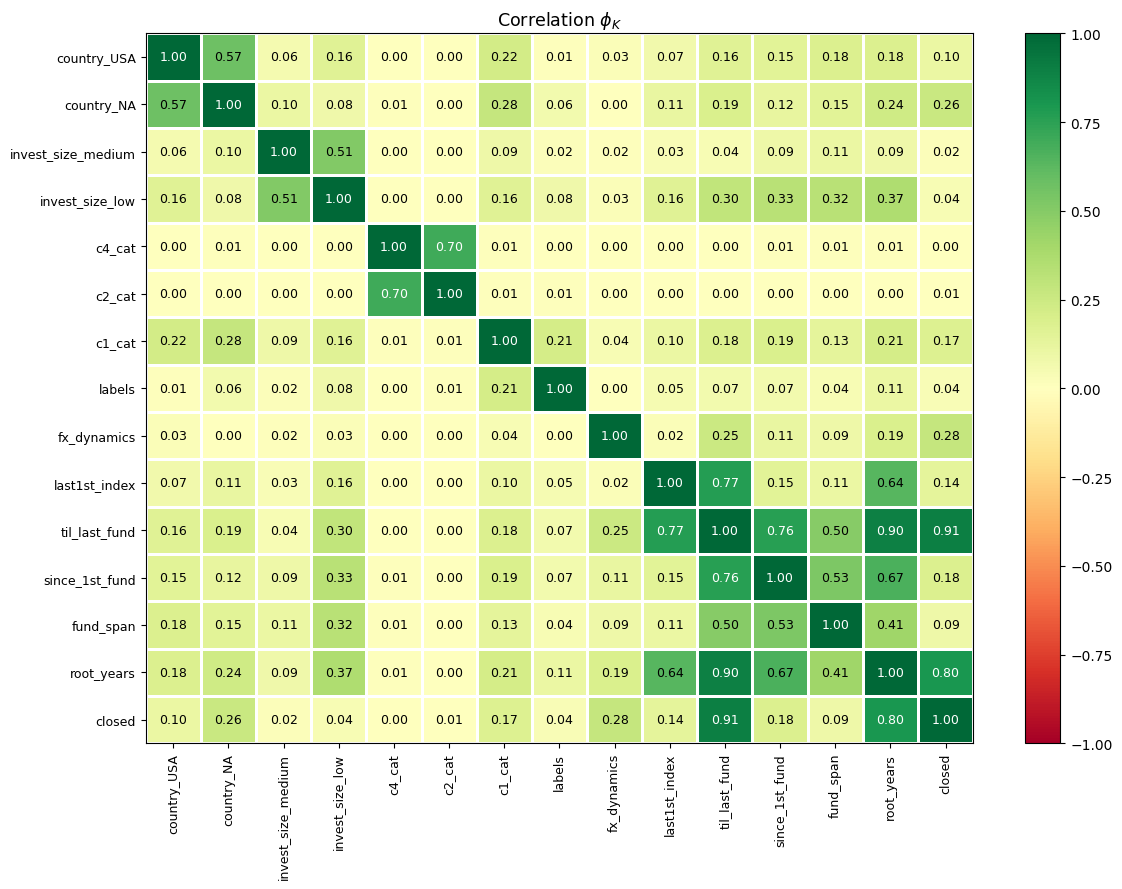

In [113]:
numeric_features = [
    # 'funding_total_usd',
    'root_years',
    'fund_span',
    'since_1st_fund',
    'til_last_fund',
    'last1st_index',
    'fx_dynamics',
    'labels',
    'c1_cat',
    'c2_cat',
    'c4_cat',
    # 'c6_cat',
    # 'c8_cat',
]

categorical_features = [
    'country',
]

ordinal_features = [
    'invest_size',
]
ordinal_categories = [
    ['low', 'medium', 'high'],
]


correlation_mtx(
    df.train,
    'closed', 
    *[*numeric_features, *ordinal_features, *categorical_features]
)



This chart was used to review the features selected for model training. It shows the pairwise correlations between these features to ensure that there is no excessive redundancy and to decide which features may need to be removed to optimize model performance.


In [114]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
            ('scaler', MinMaxScaler()),
            ('select', SelectKBest(f_classif, k='all')),
        ]), numeric_features),
        ('cat', Pipeline(steps=[
            (
                'onehot',
                OneHotEncoder(
                    drop='first', sparse_output=False, handle_unknown='ignore'
                )
            ),
            ('select', SelectKBest(score_func=chi2, k='all'))
        ]), categorical_features),
        ('ord', OrdinalEncoder(categories=ordinal_categories), ordinal_features)
    ]
)

pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTETomek(random_state=RS)),
    ('clf', RandomForestClassifier(random_state=RS)) 
])

lr_distributions = {
    'clf': [LogisticRegression(random_state=RS)],
}
dt_distributions = {
    'clf': [DecisionTreeClassifier(random_state=RS)],
}
rf_distributions = {
    'preprocessor__num__select__k': range(2, len(numeric_features) + 1),
    'clf': [RandomForestClassifier(random_state=RS)],
}


if PRODUCTION:
    rf_distributions['preprocessor__num__scaler'] = [
        MinMaxScaler(), RobustScaler()
    ]



param_distributions = [
    rf_distributions,
]


if PRODUCTION == 'deactivate':
    param_distributions += [
        lr_distributions,
        dt_distributions
    ]


random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    n_iter=N_ITER,
    scoring='f1',
    cv=CV_FOLDS,
    random_state=RS,
    verbose=2 if DEV else 1,
    n_jobs=-1
)


random_search.fit(X_train, y_train)


random_search.best_score_

/Users/ehoppe/source/github/public/2024/predict_startup_op/.venv/lib/python3.11/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 9 is smaller than n_iter=30. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 4 folds for each of 9 candidates, totalling 36 fits
[CV] END clf=RandomForestClassifier(random_state=42), preprocessor__num__select__k=2; total time=   4.3s
[CV] END clf=RandomForestClassifier(random_state=42), preprocessor__num__select__k=2; total time=   4.4s
[CV] END clf=RandomForestClassifier(random_state=42), preprocessor__num__select__k=2; total time=   4.4s
[CV] END clf=RandomForestClassifier(random_state=42), preprocessor__num__select__k=2; total time=   4.5s
[CV] END clf=RandomForestClassifier(random_state=42), preprocessor__num__select__k=3; total time=   5.0s
[CV] END clf=RandomForestClassifier(random_state=42), preprocessor__num__select__k=3; total time=   5.1s
[CV] END clf=RandomForestClassifier(random_state=42), preprocessor__num__select__k=3; total time=   5.1s
[CV] END clf=RandomForestClassifier(random_state=42), preprocessor__num__select__k=3; total time=   5.2s
[CV] END clf=RandomForestClassifier(random_state=42), preprocessor__num__select__k=4; total time=   

0.8594585223365809

In [115]:
@dataclass
class Model:
    best: RandomForestClassifier | LogisticRegression | DecisionTreeClassifier
    search: RandomizedSearchCV
    threshold: float | None = None

    @staticmethod
    def print_f1_score(treshold: float, f1: float, brackets: str = 'Test'):
        if brackets == 'Tests':
            print('Treshold: ', treshold)
        print(f'F1 Score ({brackets}): {f1:.4f}', BR) 

    @staticmethod
    def print_params(search: RandomizedSearchCV | None, treshold: float, f1: float):
        print(search.best_params_)
        print('F1-Score (Cross Validation):', search.best_score_, BR, BR)
        Model.print_f1_score(treshold, f1)


    @staticmethod
    def display_params(
        search: RandomizedSearchCV,
        val_dict: dict[str, dict[str, pd.Series]],
        test_key: str,
        probabilities: np.ndarray,
        treshold: float = 0.5,
        return_y_pred: bool = False
    ) -> None | np.ndarray:

        y_pred = (probabilities > treshold).astype(int)
        y_val = val_dict[test_key.split('__')[0]][test_key.split('__')[1]]
        Model.print_params(search, treshold, f1_score(y_val, y_pred))
        if return_y_pred:
            return y_pred

    @staticmethod
    def training_overview(
            random_search: RandomizedSearchCV,
            validation: dict[str, dict[str, pd.Series]],
            val_keys: tuple[str, str] = ('val_40', 'test_60')
        ) -> 'Model':

        model = Model(best=random_search.best_estimator_, search=random_search)

        y_pred = Model.display_params(
            search=random_search,
            val_dict=validation,
            test_key=f'{val_keys[0]}__y',
            probabilities=model.best.predict_proba(validation[val_keys[0]]['X'])[:, 1],
            return_y_pred=True
        )

        search_score = 0.0
        search_treshold = 0.0

        test_proba = model.best.predict_proba(validation[val_keys[1]]['X'])[:, 1]

        for treshold_ in range(1, 1_000):
            y_pred = (test_proba > treshold_ / 1_000).astype(int) 
            f1 = f1_score(validation[val_keys[1]]['y'], y_pred)
            if f1 > search_score:
                search_score = f1
                search_treshold = treshold_ / 1_000

        model.threshold = search_treshold
        print('New Treshold', model.threshold, BR)
        
        Model.print_f1_score(
            search_treshold,
            search_score,
            brackets=f'Treshold: {search_treshold:.2%}'
        )
        return model


In [116]:
model = Model.training_overview(
    random_search, validation, val_keys=('val_100', 'val_100')
)


val_100_threshold = model.threshold

val_100_threshold

{'preprocessor__num__select__k': 10, 'clf': RandomForestClassifier(random_state=42)}
F1-Score (Cross Validation): 0.8594585223365809 
 

F1 Score (Test): 0.8365 

New Treshold 0.84 

F1 Score (Treshold: 84.00%): 0.8689 



0.84

In [117]:
model = Model.training_overview(
    random_search, validation, val_keys=('val_40', 'test_60')
)

{'preprocessor__num__select__k': 10, 'clf': RandomForestClassifier(random_state=42)}
F1-Score (Cross Validation): 0.8594585223365809 
 

F1 Score (Test): 0.8245 

New Treshold 0.76 

F1 Score (Treshold: 76.00%): 0.8741 



In [118]:
X = validation['val_40']['X']
y = validation['val_40']['y']


skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


thresholds = np.arange(0.1, 0.9, 0.01)
f1_scores = []


for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model.best.fit(X_train, y_train)
    y_proba = model.best.predict_proba(X_test)[:, 1]
    
    f1_scores_fold = []
    for threshold in thresholds:
        y_pred = (y_proba >= threshold).astype(int)
        f1 = f1_score(y_test, y_pred)
        f1_scores_fold.append(f1)
    
    f1_scores.append(f1_scores_fold)


mean_f1_scores = np.mean(f1_scores, axis=0)

optimal_threshold = thresholds[np.argmax(mean_f1_scores)]
print(f"Optimal Threshold: {optimal_threshold}")

final_predictions = (
    (model.best.predict_proba(validation['test_60']['X'])[:, 1] >= optimal_threshold)
    .astype(int)
)
final_f1_score = f1_score(validation['test_60']['y'], final_predictions)
print(f"Final F1-Score: {final_f1_score}")

Optimal Threshold: 0.7899999999999996
Final F1-Score: 0.8494492044063647


### Feature Importance

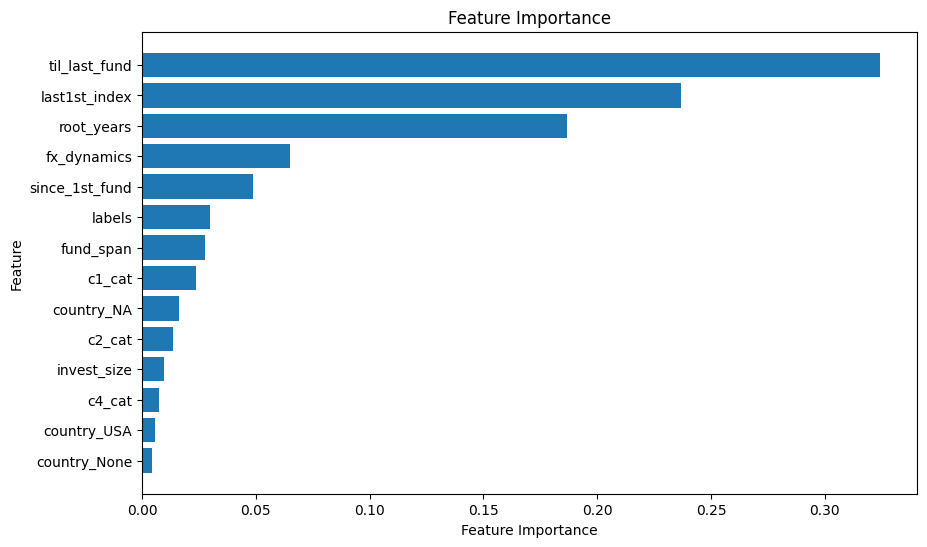

In [119]:
preprocessor = model.best.named_steps['preprocessor']
clf = model.best.named_steps['clf']

num_selected_indices = (
    preprocessor.named_transformers_['num'].named_steps['select'].get_support(
        indices=True
    )
)
cat_selected_indices = (
    preprocessor.named_transformers_['cat'].named_steps['select'].get_support(
        indices=True
    )
)
num_selected_features = [numeric_features[i] for i in num_selected_indices]
cat_selected_features = (
    preprocessor.named_transformers_['cat'].named_steps['onehot']
    .get_feature_names_out(categorical_features)[cat_selected_indices]
)
ord_selected_features = ordinal_features


all_selected_features = np.concatenate(
    [num_selected_features, cat_selected_features, ord_selected_features]
)

feature_importances = clf.feature_importances_


feature_importance_df = pd.DataFrame({
    'Feature': all_selected_features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)


plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

The chart shows that a few features, particularly `til_1st_fund`, `last1st_index`, and `root_years`, have the greatest impact on the model's predictions. These features should be given special consideration in analysis and further modeling steps, while features with lesser importance could potentially be removed to simplify the model and improve its efficiency.

In [120]:
y_pred_ = (model.best.predict_proba(validation['val_100']['X'])[:, 1] > optimal_threshold)
y_pred = y_pred_.astype(int) 

f1 = f1_score(validation['val_100']['y'], y_pred)
recall = recall_score(validation['val_100']['y'], y_pred)
precision = precision_score(validation['val_100']['y'], y_pred)


f1, recall, precision, model.threshold, optimal_threshold

(0.8850325379609545,
 0.8192771084337349,
 0.9622641509433962,
 0.76,
 0.7899999999999996)

## Production


### Model


In [121]:
if PRODUCTION:
    model.best.fit(df.train.drop(columns=['closed']), df.train['closed'])

model.best

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler()),
                                                                  ('select',
                                                                   SelectKBest())]),
                                                  ['root_years', 'fund_span',
                                                   'since_1st_fund',
                                                   'til_last_fund',
                                                   'last1st_index',
                                                   'fx_dynamics', 'labels',
                                                   'c1_cat', 'c2_cat',
                                                   'c4_cat']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False)),
                                                                  ('select',
                                                                   SelectKBest(k='all',
                                                                               score_func=<function chi2 at 0x179438720>))]),
                                                  ['country']),
                                                 ('ord',
                                                  OrdinalEncoder(categories=[['low',
                                                                              'medium',
                                                                              'high']]),
                                                  ['invest_size'])])),
                ('smote', SMOTETomek(random_state=42)),
                ('clf', RandomForestClassifier(random_state=42))])

### Prediction


In [122]:
df.test['status'] = (
    (model.best.predict_proba(df.test)[:, 1] > optimal_threshold).astype(int)
)
df.test = df.norm_target(df.test, reverse=True)



df.test[['name', 'status']].sample(10,random_state=RS)

,name,status
4975,Idomoo,operating
11026,VoxPop Network Corporation,operating
11797,THUBIT,operating
8015,Donate Your Desktop,operating
10972,Krowdpad,operating
7628,Capptú,operating
11275,Miniversum,operating
2316,Braclet,operating
5862,Elephanti,operating
6041,CommunityOne Bank,operating


### Closed-Ratio


In [123]:
print_percentage = (
    lambda label, count, total: print(f"{round(count / total * 100, 4)}% {label}")
)
print_percentage('Train', df.train['closed'].sum(), len(df.train))
print_percentage(
    'Validation (Test)',
    validation['val_100']['y'].sum(),
    len(validation['val_100']['y']),
)
print_percentage('Validation (Prediction)', y_pred.sum(), len(y_pred))
print_percentage(
    'Test (Kaggle)', len(df.test[df.test['status'] == 'closed']), len(df.test)
)


9.335% Train
9.3375% Validation (Test)
7.95% Validation (Prediction)
7.901% Test (Kaggle)


A discrepancy between the predicted and actual values is observed. This work can be further improved through targeted model calibration as well as optimization of model complexity and regularization.

In [124]:
if PRODUCTION:
    df.test[['name', 'status']].to_csv('submission.csv', index=False)
else:
    df.test[['name', 'status']].sample(10, random_state=RS).to_csv(
        'submission_sample.csv', index=False
    )


## Conclusion (TODO:Update Content)

In this project, a pipeline was developed that processes numerical, categorical, and ordinal features and combines them with a RandomForest classifier. After comprehensive hyperparameter optimization with RandomizedSearchCV, the optimal parameters for the model were identified. 

The model achieved an F1 score of `0.8546` in cross-validation, indicating a good balance between precision and recall. In the test set, the model achieved a slightly lower F1 score of `0.8324`, indicating consistent model performance.

By adjusting the threshold to `0.784`, the F1 score was further improved to `0.8555`. This adjustment shows that fine-tuning the threshold can further optimize model performance, particularly in terms of the specific balance between prediction goals.
